# Creating the final plots
In this notebook, I fit the model using all of the data to create the final plot.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

# SKLEARN modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import griddata

import sys
sys.path.append('../')
from src.utils import (
    load_dataset,
    create_folds,
    standardize_data,
    generate_data,
    create_weight_matrix,
)

from Datasets.spatial_dataset import SpatialDataset

In [77]:
# Print out the args
data_dir = "../data/boston/"
window_size = 25
use_coords = False
ndvi_ls = 26
albedo_ls = 8
l2_alpha = 1
city = "boston"

In [78]:
data = load_dataset(data_dir, window_size, city)

In [79]:
idx = range(len(data.coords))
X, y = generate_data(data, idx, ndvi_ls, albedo_ls, window_size, False)

In [80]:
# Now, we need to standardize the data for the final fit
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

In [81]:
# Needed for the GP
from scipy.optimize import minimize

def optimizer(obj_func, initial_theta, bounds):

    opt_res =  minimize(obj_func, initial_theta, method='L-BFGS-B', bounds=bounds, jac=True, options = {'maxiter':1000})    

    return opt_res.x, opt_res.fun

In [83]:
ridge_y = y_train
current_score = 1
for i in range(20):
    print("iteration ", i)
    lm = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, ridge_y)
    preds = lm.predict(x_train)

    print("\t Ridge R2 score: ", r2_score(y_train, preds))
    if r2_score(y_train, preds) > current_score:
        break
    current_score = r2_score(y_train, preds)
    coords = data.coords

    residuals = y_train - preds

    N = 1000
    sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
    sample_points = coords[sample_idx, :]
    sample_residuals = residuals[sample_idx]

    kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
    gpr = GaussianProcessRegressor(kernel = kernel, alpha=1e-4, random_state=100, n_restarts_optimizer=10)

    gpr.fit(sample_points, sample_residuals)

    U = gpr.predict(coords)
    ridge_y = y_train - U

iteration  0
	 Ridge R2 score:  0.48057544649342787
iteration  1
	 Ridge R2 score:  0.47746927706258124
iteration  2
	 Ridge R2 score:  0.4746277057339213
iteration  3
	 Ridge R2 score:  0.47081205063537357
iteration  4
	 Ridge R2 score:  0.4632872194615175
iteration  5
	 Ridge R2 score:  0.45948421270871653
iteration  6
	 Ridge R2 score:  0.45344165872197617
iteration  7
	 Ridge R2 score:  0.45448909230084944


In [84]:
print(lm.score(x_train, y_train))

0.45448909230084944


In [85]:
residuals = y_train - preds

N = 1000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
gpr = GaussianProcessRegressor(kernel = kernel, alpha=1e-4, random_state=100, n_restarts_optimizer=10)

gpr.fit(sample_points, sample_residuals)

GaussianProcessRegressor(alpha=0.0001,
                         kernel=0.707**2 * Matern(length_scale=115, nu=0.5) + 0.000548**2 * DotProduct(sigma_0=0.1),
                         n_restarts_optimizer=10, random_state=100)

In [86]:
U = gpr.predict(coords)

In [87]:
r2_score(y_train, preds + U)

0.9103892410082797

Ok -- this model aligns well with the bootstrapped results. Now, we can go ahead and create the updated plots using these results.

In [12]:
all_data = SpatialDataset(data_dir, nlcd_ws=window_size, ndvi_ws=window_size, albedo_ws=window_size, ndvi_ls=ndvi_ls, albedo_ls=albedo_ls, city=city)

In [13]:
import joblib

In [14]:
# Storing this for future use
joblib.dump(all_data, "../temp/all_data.joblib")

['../temp/all_data.joblib']

In [15]:
all_data = joblib.load("../temp/all_data.joblib")

In [17]:
all_data.ndvi_spatial.shape

(3307, 2770)

# Let's confirm that this data fits the model the exact same way

In [88]:
predictors = np.concatenate([
    all_data.nlcd.reshape(-1, 15),
    all_data.ndvi.reshape(-1,1),
    all_data.ndvi_spatial.reshape(-1,1),
    all_data.albedo.reshape(-1, 1),
    all_data.albedo_spatial.reshape(-1, 1)], axis=1)

In [89]:
predictors = (predictors - x_shift[np.newaxis, :]) / (x_scale[np.newaxis, :] + 1e-16)

In [90]:
# predictors[:, 2:] = 0
pred_temp = lm.predict(predictors)

In [91]:
pred_temp = pred_temp.reshape(all_data.ndvi.shape[0], all_data.ndvi.shape[1])

In [92]:
pred_temp = pred_temp*y_std + y_mean

# Print out the 95% percentile
print(np.percentile(pred_temp.flatten(), [2.5, 97.5]))

[26.89711321 30.0936801 ]


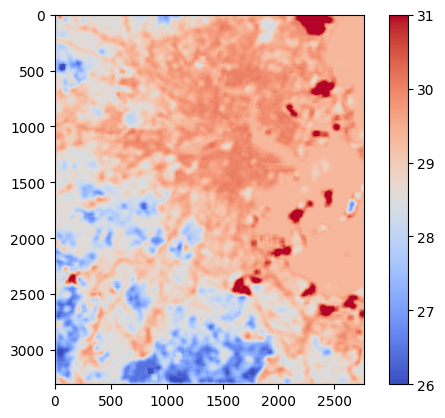

In [93]:
plt.imshow(pred_temp, cmap='coolwarm', vmin=26, vmax=31)
plt.colorbar()

# Let's create the maps now

In [94]:
import rasterio as rio
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.ticker as mticker

<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\d'
C:\Users\esl26\AppData\Local\Temp\ipykernel_24524\249365237.py:26: SyntaxWarning: invalid escape sequence '\c'
  cbar = fig.colorbar(ig, cax=cbar_ax, label='Temperature ($^\circ C$)', orientation='horizontal')#, pad=0.05, shrink=0.9)
C:\Users\esl26\AppData\Local\Temp\ipykernel_24524\249365237.py:28: SyntaxWarning: invalid escape sequence '\d'
  cbar.ax.set_xlabel('Temperature ($\degree C$)', fontsize=24)
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:487: U

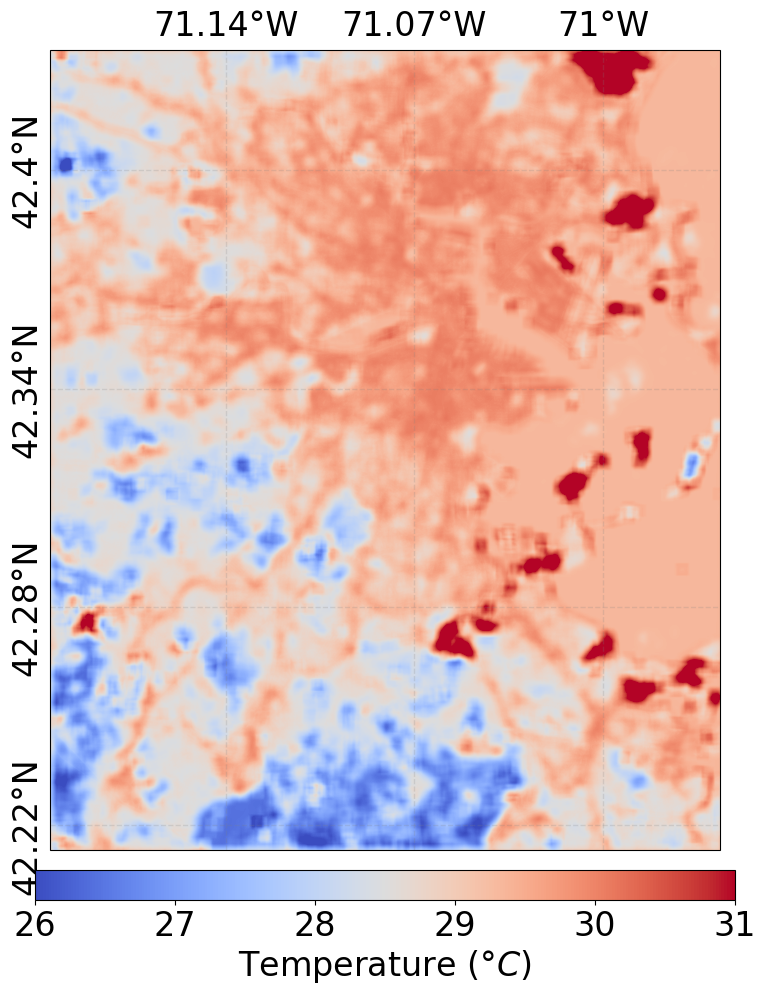

In [95]:
# Let's plot the map by copying the lat/lon information from the temperature dataset.
import os
base_path = '../data/boston/'
with rio.open(os.path.join(base_path, 'boston_temp.tif')) as src:
    bounds = src.bounds

img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# Set up the figure with axes
fig = plt.figure(figsize=(10,10)) #, layout='constrained')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8] , projection=ccrs.epsg(3857))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--', ylabel_style={'size': 24, 'rotation': 'vertical'}, xlabel_style={'size': 24})
# Remove edge effects for a better visual
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-71.0, -71.07, -71.14, -71.21])
gl.ylocator = mticker.FixedLocator([42.22, 42.28, 42.34, 42.4])


ig = ax.imshow(pred_temp, cmap='coolwarm', extent=img_extent, vmax=31, vmin=26)#, transform=ccrs.PlateCarree())

# Set up axis and apply
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = fig.colorbar(ig, cax=cbar_ax, label='Temperature ($^\circ C$)', orientation='horizontal')#, pad=0.05, shrink=0.9)
cbar.ax.tick_params(labelsize=24)
cbar.ax.set_xlabel('Temperature ($\degree C$)', fontsize=24)
plt.savefig('../figures/boston_temp_celsius_no_confounding.png', dpi=300, bbox_inches='tight')
# ax.show()

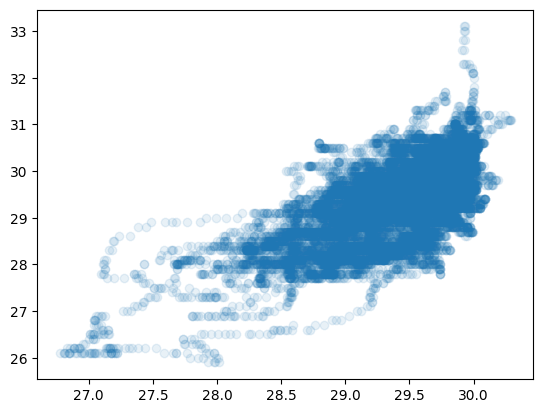

In [96]:
# pred_temp_c = pred_temp_c.reshape(all_data.ndvi.shape[0], all_data.ndvi.shape[1])
pred_flat = pred_temp[all_data.temp != 0]
true_flat = all_data.temp[all_data.temp != 0]

plt.scatter(pred_flat, true_flat, alpha=0.1)


In [98]:
# Print out the R^2 of the model
print(r2_score(true_flat, pred_flat))

0.45448909230084955


# Now, let's look at the residuals for this map and apply the Gaussian Process to get the correction.

In [99]:
mask = all_data.temp != 0

# Apply correction
temp_mean = np.mean(all_data.temp[mask])
temp_std = np.std(all_data.temp[mask])

true_temp = (all_data.temp - temp_mean) / temp_std

coords = np.array(np.where(mask)).T

pred_temp = (pred_temp - temp_mean) / temp_std

residuals = true_temp[mask] - pred_temp[mask]

N = 2000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [100]:
print(true_temp[mask])

[ 1.29005712  1.29005712  1.29005712 ... -0.59031082 -0.59031082
 -0.59031082]


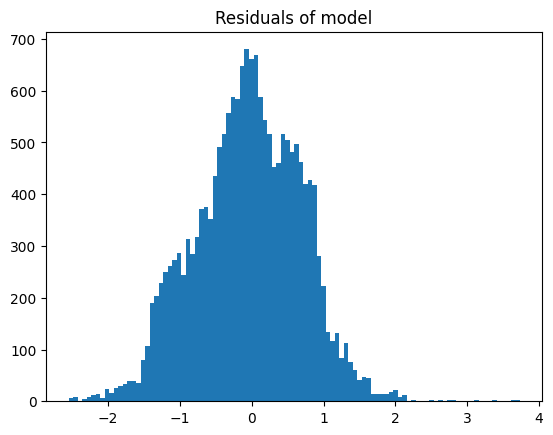

In [101]:
plt.hist(residuals, bins=100)
plt.title("Residuals of model")
plt.show()

In [102]:
X_train, X_test, y_train, y_test = train_test_split(sample_points, sample_residuals, test_size=0.5, random_state=42)

In [103]:
from scipy.optimize import minimize

def optimizer(obj_func, initial_theta, bounds):

    opt_res =  minimize(obj_func, initial_theta, method='L-BFGS-B', bounds=bounds, jac=True, options = {'maxiter':1000})    

    return opt_res.x, opt_res.fun

In [104]:
# Let's select the points that we want to downsample from in the image.
# Note -- the coordinate system is in pixels, relative to the origin, and not the actual
# coordinate values. This is OK in our case, since we are using the Pseudo-mercator
# projection, which has equal spacing in the x and y directions.
x = np.arange(0, true_temp.shape[0])
y = np.arange(0, true_temp.shape[1])

# Get the meshgrid of the points
(x_grid, y_grid) = np.meshgrid(x, y)

# Downsample the points, by only getting every 10th point
ds = 10
x_downsample = x_grid[::ds, ::ds]
y_downsample = y_grid[::ds, ::ds]

# Stack the x and y coordinates
coords = np.vstack((x_downsample.flatten(), y_downsample.flatten())).T

print(len(coords))

91687


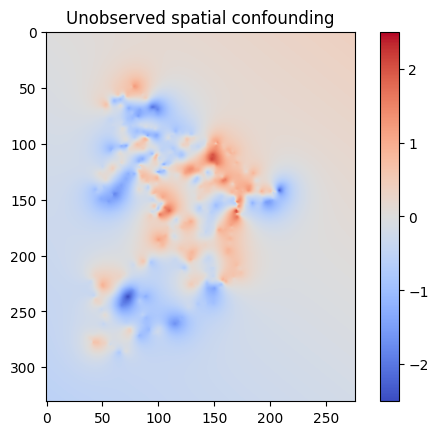

In [105]:
# Now, we can actually look at the output of the model to see how the model
# is predicting the unobserved confounding.
output = gpr.predict(coords)
res_grid = output.reshape(x_downsample.shape)
plt.imshow(res_grid.T, cmap='coolwarm', vmin=-2.5, vmax=2.5)
plt.colorbar()
plt.title("Unobserved spatial confounding")
plt.show()

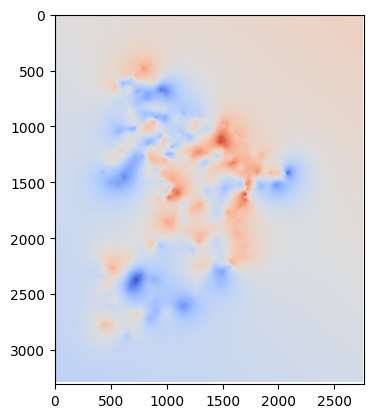

In [107]:
# Get the coordinates of the original grid
x_orig = np.arange(0, true_temp.shape[0])
y_orig = np.arange(0, true_temp.shape[1])
(x_orig_grid, y_orig_grid) = np.meshgrid(x_orig, y_orig)

# Interpolate
interp_grid = griddata(coords, output, (x_orig_grid, y_orig_grid), method='linear')

plt.imshow(interp_grid.T, cmap='coolwarm', vmin=-2.5, vmax=2.5)
plt.show()

In [108]:
# Let's correct the residuals to be in Celsius
res_corrected_c = interp_grid.T * y_std

np.nanpercentile(res_corrected_c, [2.5, 97.5])

array([-0.7926982 ,  0.58778113])

<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\d'
C:\Users\esl26\AppData\Local\Temp\ipykernel_24524\478241977.py:24: SyntaxWarning: invalid escape sequence '\c'
  cbar = fig.colorbar(ig, cax=cbar_ax, label='Temperature ($^\circ C$)', orientation='horizontal')#, pad=0.05, shrink=0.9)
C:\Users\esl26\AppData\Local\Temp\ipykernel_24524\478241977.py:26: SyntaxWarning: invalid escape sequence '\d'
  cbar.ax.set_xlabel('Temperature ($\degree C$)', fontsize=24)
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:487: U

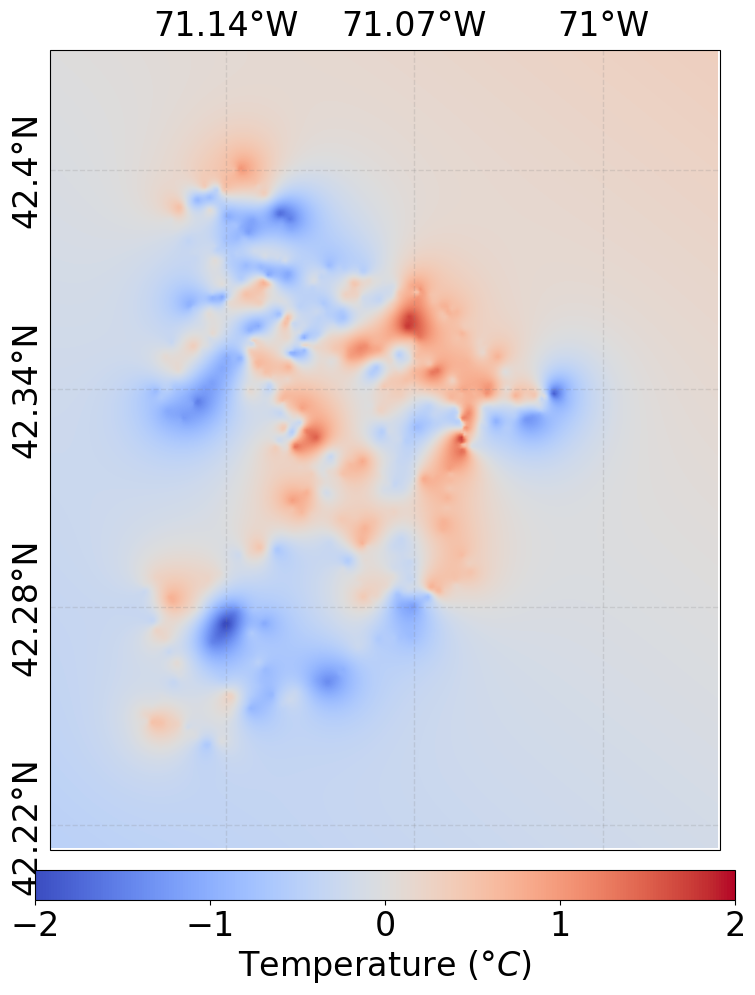

In [109]:
with rio.open(os.path.join(base_path, 'boston_temp.tif')) as src:
    bounds = src.bounds

img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)


fig = plt.figure(figsize=(10,10)) #, layout='constrained')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8] , projection=ccrs.epsg(3857))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--', ylabel_style={'size': 24, 'rotation': 'vertical'}, xlabel_style={'size': 24})
# Remove edge effects for a better visual
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-71.0, -71.07, -71.14, -71.21])
gl.ylocator = mticker.FixedLocator([42.22, 42.28, 42.34, 42.4])


ig = ax.imshow(res_corrected_c, cmap='coolwarm', extent=img_extent, vmax=2, vmin=-2)#, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])

# cbar = plt.colorbar(label='Temperature ($^\circ C$)', orientation='horizontal', pad=0.05, shrink=0.9)
cbar = fig.colorbar(ig, cax=cbar_ax, label='Temperature ($^\circ C$)', orientation='horizontal')#, pad=0.05, shrink=0.9)
cbar.ax.tick_params(labelsize=24)
cbar.ax.set_xlabel('Temperature ($\degree C$)', fontsize=24)
plt.savefig('../figures/boston_unobs_confounding.png', dpi=300, bbox_inches='tight')
plt.show()

# Now, let's create the final map

In [110]:
pred_temp = pred_temp * temp_std + temp_mean

In [111]:
final_pred = pred_temp + interp_grid.T

In [112]:
np.nanpercentile(final_pred, [2.5, 97.5])

array([26.49426378, 30.6914188 ])

<>:18: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\d'
C:\Users\esl26\AppData\Local\Temp\ipykernel_24524\3001138608.py:18: SyntaxWarning: invalid escape sequence '\c'
  cbar = fig.colorbar(ig, cax=cbar_ax, label='Temperature ($^\circ C$)', orientation='horizontal')#, pad=0.05, shrink=0.9)
C:\Users\esl26\AppData\Local\Temp\ipykernel_24524\3001138608.py:20: SyntaxWarning: invalid escape sequence '\d'
  cbar.ax.set_xlabel('Temperature ($\degree C$)', fontsize=24)
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:487:

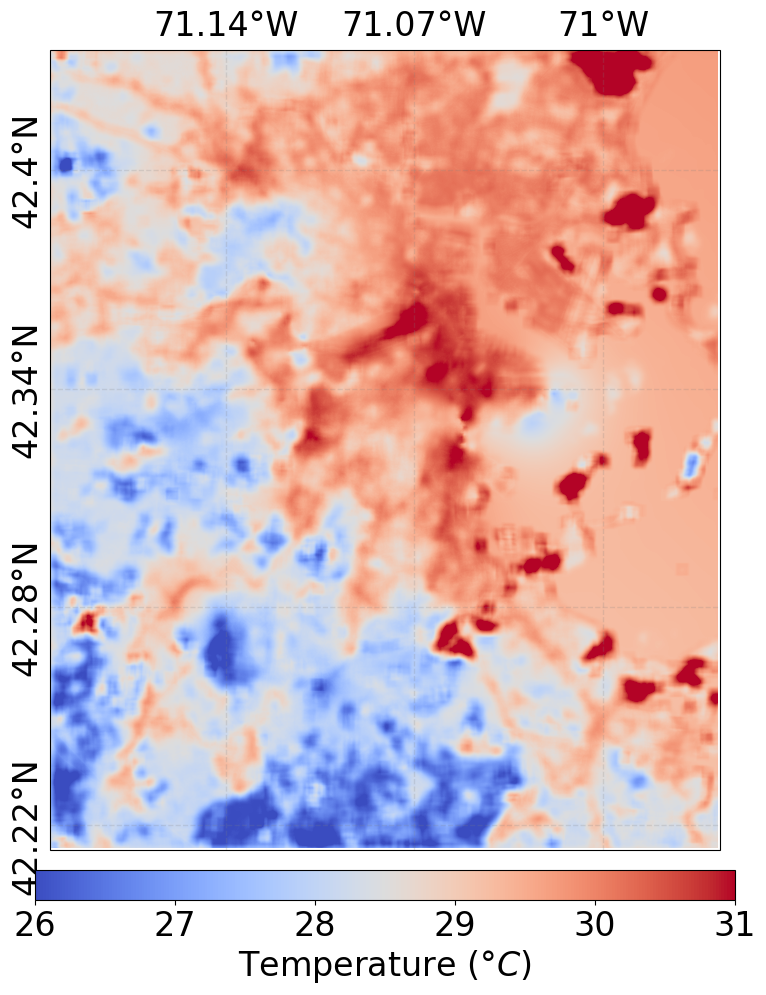

In [113]:
img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
fig = plt.figure(figsize=(10,10)) #, layout='constrained')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8] , projection=ccrs.epsg(3857))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--', ylabel_style={'size': 24, 'rotation': 'vertical'}, xlabel_style={'size': 24})
# Remove edge effects for a better visual
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-71.0, -71.07, -71.14, -71.21])
gl.ylocator = mticker.FixedLocator([42.22, 42.28, 42.34, 42.4])


ig = ax.imshow(final_pred, cmap='coolwarm', extent=img_extent, vmax=31, vmin=26)#, transform=ccrs.PlateCarree())


cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = fig.colorbar(ig, cax=cbar_ax, label='Temperature ($^\circ C$)', orientation='horizontal')#, pad=0.05, shrink=0.9)
cbar.ax.tick_params(labelsize=24)
cbar.ax.set_xlabel('Temperature ($\degree C$)', fontsize=24)
plt.savefig('../figures/boston_temp_celsius.png', dpi=300, bbox_inches='tight')
plt.show()

In [116]:
true_temp_vals = all_data.temp[all_data.temp != 0]
# Convert to Celsius
# true_temp_vals = (true_temp_vals - 32)*5/9
pred_temp_vals = final_pred[all_data.temp != 0]

# Print out r2 score
print(r2_score(pred_temp_vals, true_temp_vals))

0.9087824321241597


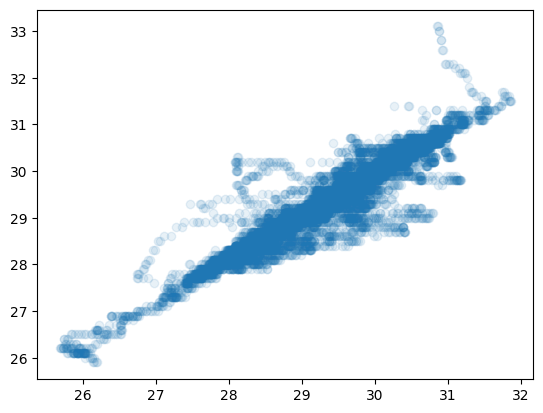

In [117]:
plt.scatter(pred_temp_vals, true_temp_vals, alpha=0.1)

The problem with ignoring the lat/lon trend is that we might be overestimating the causal effect, and thus, we should err on the side of caution.

What would be a way to control for this? Well, we could check the statistic for 

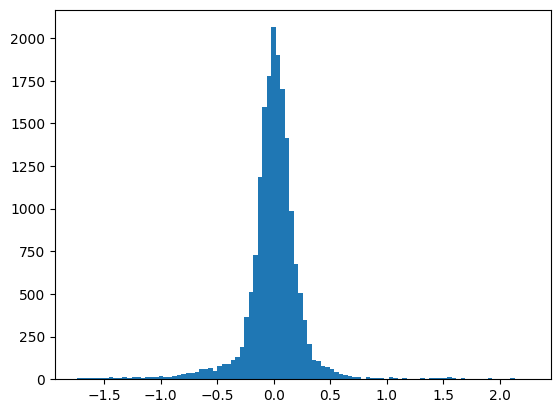

In [118]:
residuals = true_temp_vals - pred_temp_vals

plt.hist(residuals, bins=100)
plt.show()

In [119]:
mask = all_data.temp != 0

# Apply correction
temp_mean = np.mean(all_data.temp[mask])
temp_std = np.std(all_data.temp[mask])

true_temp = (all_data.temp - temp_mean) / temp_std

coords = np.array(np.where(mask)).T

residuals = true_temp_vals - pred_temp_vals

N = 2000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

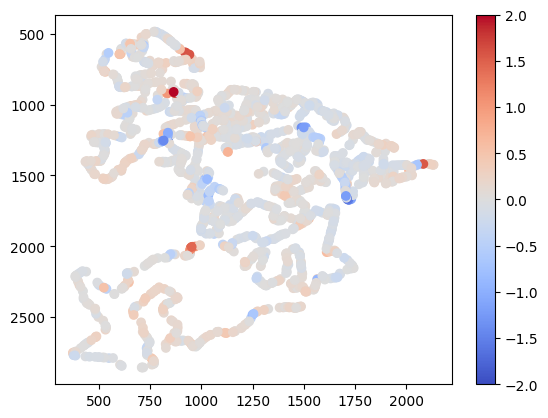

In [120]:
plt.scatter(sample_points[:, 1], sample_points[:, 0], c=sample_residuals, cmap='coolwarm', vmin=-2, vmax=2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()